# VHR example
Let's use EOReader with Very High Resolution data.

<div class="alert alert-warning">
  
<strong>Warning:</strong> 
   <li> We do not provide Pleiades data
   <li> You will need <strong>matplotlib</strong> to complete this tutorial
</div>

In [1]:
import os
import glob

# First of all, we need some VHR data, let's use Pleiades data
path = glob.glob(os.path.join("/home", "data", "DATA", "PRODS", "PLEIADES", "5547047101", "IMG_PHR1A_PMS_001"))[0]

In [2]:
# Create logger
import logging

logger = logging.getLogger("eoreader")
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [3]:
from eoreader.reader import Reader

# Create the reader
eoreader = Reader()

In [4]:
from eoreader.bands.alias import *

# Open your product
prod = eoreader.open(path, remove_tmp=True)
print(f"Acquisition datetime: {prod.datetime}")
print(f"Condensed name: {prod.condensed_name}")

# Please be aware that EOReader will always work in UTM projection, so if you give WGS84 data,
# EOReader will reproject the stacks and this can be time consuming

Acquisition datetime: 2020-05-11 02:31:58
Condensed name: 20200511T023158_PLD_ORT_PMS


In [5]:
# Here, if you want to orthorectify or pansharpen your data manually, you can set your stack here.
# If you do not provide this stack but you give a non-orthorectified product to EOReader 
# (ie. SEN or PRJ products for Pleiades), you must provide a DEM to orthorectify correctly the data
# prod.ortho_stack = ""
from eoreader.env_vars import DEM_PATH
os.environ[DEM_PATH] = os.path.join("/home", "data", "DS2", "BASES_DE_DONNEES", "GLOBAL", "MERIT_Hydrologically_Adjusted_Elevations", "MERIT_DEM.vrt")

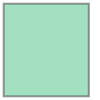

In [6]:
# Open here some more interesting geographical data: extent
extent = prod.extent()
extent.geometry.to_crs("EPSG:4326").iat[0]  # Display

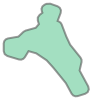

In [7]:
# Open here some more interesting geographical data: footprint
footprint = prod.footprint()
footprint.geometry.to_crs("EPSG:4326").iat[0]  # Display

In [8]:
# Select the bands you want to load
bands = [GREEN, NDVI, TIR_1, CLOUDS, HILLSHADE]

# Be sure they exist for Pleiades sensor:
ok_bands = [band for band in bands if prod.has_band(band)]
print(to_str(ok_bands)) # Pleiades doesn't provide TIR and SHADOWS bands

['GREEN', 'NDVI', 'CLOUDS', 'HILLSHADE']


In [9]:
# Load those bands as a dict of xarray.DataArray
band_dict = prod.load(ok_bands)
band_dict[GREEN]

Reprojecting band GREEN to UTM with a 0.5 m resolution.


Reprojecting band RED to UTM with a 0.5 m resolution.


Reprojecting band NIR to UTM with a 0.5 m resolution.


<xarray.DataArray 'GREEN' (band: 1, y: 18124, x: 16754)>
dask.array<where, shape=(1, 18124, 16754), dtype=float32, chunksize=(1, 4005, 16754), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.024e+05 7.024e+05 ... 7.108e+05 7.108e+05
  * y            (y) float64 9.689e+06 9.689e+06 9.689e+06 ... 9.68e+06 9.68e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     GREEN

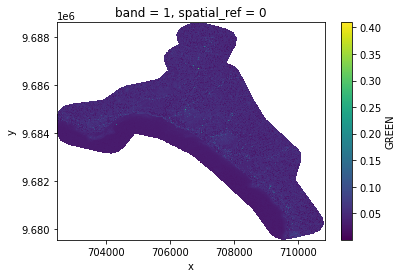

In [10]:
# The nan corresponds to the nodata you see on the footprint
%matplotlib inline

# Plot a subsampled version
band_dict[GREEN][:, ::10, ::10].plot()

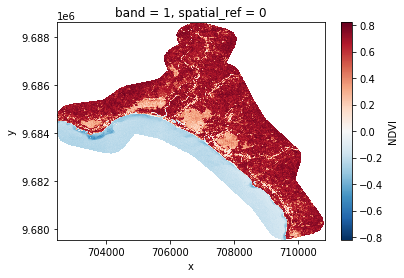

In [11]:
# Plot a subsampled version
band_dict[NDVI][:, ::10, ::10].plot()

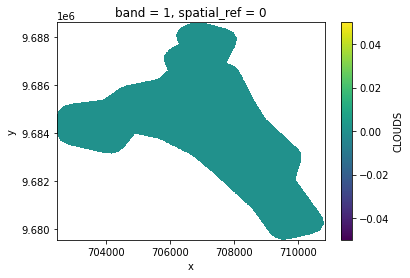

In [12]:
# Plot a subsampled version
band_dict[CLOUDS][:, ::10, ::10].plot()

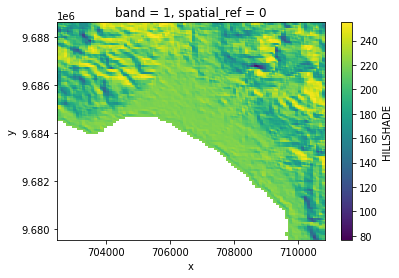

In [13]:
# Plot a subsampled version
band_dict[HILLSHADE][:, ::10, ::10].plot()

In [14]:
# You can also stack those bands
stack = prod.stack(ok_bands)
stack

<xarray.DataArray 'NDVI_GREEN_HILLSHADE_CLOUDS' (z: 4, y: 18124, x: 16754)>
dask.array<astype, shape=(4, 18124, 16754), dtype=float32, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 7.024e+05 7.024e+05 ... 7.108e+05 7.108e+05
  * y            (y) float64 9.689e+06 9.689e+06 9.689e+06 ... 9.68e+06 9.68e+06
  * z            (z) MultiIndex
  - variable     (z) object 'NDVI' 'GREEN' 'HILLSHADE' 'CLOUDS'
  - band         (z) int64 1 1 1 1
Attributes:
    long_name:  ['NDVI', 'GREEN', 'HILLSHADE', 'CLOUDS']

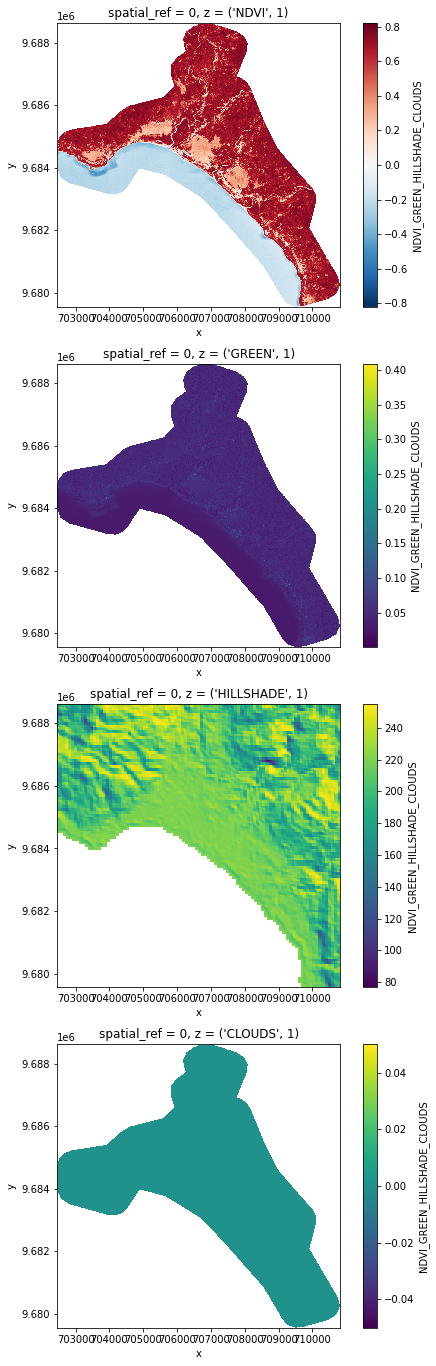

In [15]:
# Error in plotting with a list
if "long_name" in stack.attrs:
    stack.attrs.pop("long_name")

# Plot a subsampled version
import matplotlib.pyplot as plt
nrows = len(stack)
fig, axes = plt.subplots(nrows=nrows, figsize=(2*nrows, 6*nrows), subplot_kw={"box_aspect": 1})
for i in range(nrows):
    stack[i, ::10, ::10].plot(x="x", y="y", ax=axes[i])